# Collecting out-of-distribution images using OODTrigger

#TODO : 

Clearer /shorter descriptions across the notebook
About OOD  and why is it useful
What is going to be done in this notebook. 



In [1]:
# As usual, we will connect to the platform first, using the server details from the .env file
import os

from geti_sdk import Geti
from geti_sdk.utils import get_server_details_from_env

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"

geti_server_configuration = get_server_details_from_env(
    env_file_path="/Users/rgangire/workspace/code/repos/Geti-SDK/dev/geti-sdk/notebooks/use_cases/.env"
)

geti = Geti(server_config=geti_server_configuration)

## Selecting a project

We'll use the `CUB6` project that is already created. This project contains 6 classes of birds with each class having 50 images. The project is already trained and ready for deployment.


In [2]:
from geti_sdk.rest_clients import ModelClient, ProjectClient

PROJECT_NAME = "CUB6"

project_client = ProjectClient(session=geti.session, workspace_id=geti.workspace_id)
project = project_client.get_project_by_name(project_name=PROJECT_NAME)
model_client = ModelClient(
    session=geti.session, workspace_id=geti.workspace_id, project=project
)

## Creating a deployment for the project.

The OOD detection model uses feature vectors from the trained model to detect out-of-distribution images. Therefore we need to create a deployment with a model that has an XAI head.


In [3]:
from geti_sdk.detect_ood.utils import get_deployment_with_xai_head

deployment = get_deployment_with_xai_head(geti=geti, model_client=model_client)

2024-09-10 14:56:27,643 - INFO - Loading faiss.
2024-09-10 14:56:27,659 - INFO - Successfully loaded faiss.
2024-09-10 14:56:35,009 - INFO - Deployment for project 'CUB6' started.
2024-09-10 14:56:35,018 - INFO - Waiting for the deployment to be created...
2024-09-10 14:56:38,929 - INFO - Downloading project deployment archive...
2024-09-10 14:56:45,009 - INFO - Deployment for project 'CUB6' downloaded and extracted successfully.


## Creating the Combined Out-of-Distribution (COOD) Model

COOD is a framework for OOD detection model that combines individual OOD measures into one combined OOD (COOD) measure using a supervised model.

The COOD model uses the images from pre-determined datasets in the Geti project to learn the in-distributions and out-of-distribution patterns. 
If out-of-distribution images are not present in the project, they are created by applying strong corruptions on the in-distribution images. 

The model runs inference on all the in-distribution and out-of-distribution images and trains a random forest classifier to combine the individual OOD measures into one COOD measure. 

In [4]:
from geti_sdk.detect_ood.ood_model import COODModel

# A directory to store the data downloaded and generated by the COOD model
ood_workspace_dir = "/Users/rgangire/workspace/Results/SDK/COOD_MODEL_WS"


# There are several ways to provide OOD images for training the COOD model.
# The simplest way is to provide a directory containing the OOD images.
# If not provided, the COOD model will check if there are any relevant datasets on Geti project that can be used as OOD images. If not, it will generate OOD images by applying strong corruptions on the in-distribution images.
ood_images_dir = "/Users/rgangire/workspace/Results/SDK/data/ood_near"

ood_model = COODModel(
    geti=geti,
    project=project,
    deployment=deployment,
    ood_images_dir=ood_images_dir,
    workspace_dir=ood_workspace_dir,
)

2024-09-10 14:56:45,261 - INFO - Reading model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp493h34_s/deployment/Classification/model/model.xml
2024-09-10 14:56:45,504 - INFO - The model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp493h34_s/deployment/Classification/model/model.xml is loaded to CPU
2024-09-10 14:56:45,506 - INFO - 	Number of model infer requests: 1
2024-09-10 14:56:45,507 - INFO - Inference model wrapper initialized, force reloading model on device `CPU` to finalize inference model initialization process.
2024-09-10 14:56:45,694 - INFO - The model /var/folders/f1/7tc0dfks1j590_v7st0w309r0000gn/T/tmp493h34_s/deployment/Classification/model/model.xml is loaded to CPU
2024-09-10 14:56:45,696 - INFO - 	Number of model infer requests: 1
2024-09-10 14:56:45,697 - INFO - Inference models loaded on device `CPU` successfully.
2024-09-10 14:56:45,697 - INFO - Building Combined OOD detection model for Intel® Geti™ project `CUB6`.
2024-09-10 14:56:45,697 - INFO - Extr

2024-09-10 14:56:50,366 - INFO - No images were downloaded. 300 existing images were found in the target folder, download was skipped for these images.


2024-09-10 14:57:04,917 - INFO - Extracting OOD data from the provided reference images in /Users/rgangire/workspace/Results/SDK/data/ood_near
2024-09-10 14:57:12,042 - INFO - Number of in-distribution samples: 300
2024-09-10 14:57:12,042 - INFO - Number of out-of-distribution samples: 349
2024-09-10 14:57:12,532 - INFO - Training COOD Model
2024-09-10 14:57:12,532 - INFO - Training data: ID - 210, OOD - 244
2024-09-10 14:57:12,614 - INFO - Mean Accuracy on Train Data: 1.0000
2024-09-10 14:57:12,615 - INFO - Mean Accuracy on Validation Data: 0.9197
2024-09-10 14:57:12,615 - INFO - AUROC on Train Data: 1.0000
2024-09-10 14:57:12,615 - INFO - AUROC on Validation Data: 0.9704
2024-09-10 14:57:12,615 - INFO - F1 Score on Train Data: 1.0000
2024-09-10 14:57:12,616 - INFO - F1 Score on Validation Data: 0.9281
2024-09-10 14:57:12,616 - INFO - COOD Model is trained and ready for inference.
2024-09-10 14:57:12,616 - INFO - Evaluating COOD Model on Test Data
2024-09-10 14:57:12,616 - INFO - Test

## Configuring a post inference hook to send the detected ood images to Geti

The COOD model is now trained. This model is now ready to detect images that can be OOD or anomalous relative to the user uploaded images in Geti. 
For a given image, the COOD model will output a score between 0 and 1. A score closer to 1 indicates that the image is OOD.

We would now use this COOD model to detect OOD images and upload them to a separate dataset in the Geti project. The idea is to collect these images and use them for further analysis or training.

For this we will add a post inference hook to the deployment. The hook will be configured to behave as follows:

- If the image has a COOD score greater than 0.5 :
- Send the image to the Geti project, to a dedicated dataset named 'OOD Images Collected'

For achieving the first part, we will use the OODTrigger, which will activate if the COOD score is greater than 0.5.
For the second part, we will use the GetiDataCollection action, which will send the image to the Geti project.

More about Triggers and Post Inference Hooks can be found in 012_post_inference_hooks.ipynb


In [5]:
from geti_sdk.post_inference_hooks import (
    FileSystemDataCollection,
    GetiDataCollection,
    OODTrigger,
    PostInferenceHook,
)

# The Trigger will activate whenever the COOD score is greater than 0.5
trigger = OODTrigger(ood_model=ood_model)

# the Action will send the detected OOD images to a new `OOD Images Collected` dataset in the Geti project
action = GetiDataCollection(
    session=geti.session,
    workspace_id=geti.workspace_id,
    project=project,
    dataset="New or Unknown Species",
    log_level="info",
)


hook = PostInferenceHook(  # The Hook attaches the action to the trigger
    trigger=trigger, action=action
)


second_action = FileSystemDataCollection(
    target_folder="/Users/rgangire/workspace/Results/SDK/data/OOD_IMAGES_COLLECTED",
    file_name_prefix="OOD_",
    save_predictions=False,
    save_scores=False,
    save_overlays=False,
)

second_hook = PostInferenceHook(  # The Hook attaches the action to the trigger
    trigger=trigger, action=second_action
)
# Add the hook to the deployment
deployment.add_post_inference_hook(hook)
deployment.add_post_inference_hook(second_hook)

2024-09-10 15:16:12,288 - INFO - Dataset `New or Unknown Species` was created in project `CUB6`
2024-09-10 15:16:12,290 - INFO - Hook `PostInferenceHook(trigger=OODTrigger(threshold=0.5), action=GetiDataCollection(target_server=`https://geti-staging.geti-staging.infra-host.com`, target_project=CUB6, target_dataset=New or Unknown Species))[Multithreaded execution enabled. ]` added.
2024-09-10 15:16:12,291 - INFO - Deployment now contains 1 post inference hooks.
2024-09-10 15:16:12,291 - INFO - Hook `PostInferenceHook(trigger=OODTrigger(threshold=0.5), action=FileSystemDataCollection(target_folder=`/Users/rgangire/workspace/Results/SDK/data/OOD_IMAGES_COLLECTED`, file_prefix=OOD_, save_predictions=False, save_scores=False, save_overlays=False))[Multithreaded execution enabled. ]` added.
2024-09-10 15:16:12,291 - INFO - Deployment now contains 2 post inference hooks.


## Inferring on an different species than the trained classes

We now infer the deployment on an image of a different species than the trained classes. 
This image is expected to be detected as OOD by the COOD model and sent to the Geti project.

Predicted as : Downy Woodpecker with a probability: 85.1%
2024-09-10 15:16:16,891 - INFO - OOD score: 1.0
2024-09-10 15:16:16,892 - INFO - OOD score: 1.0


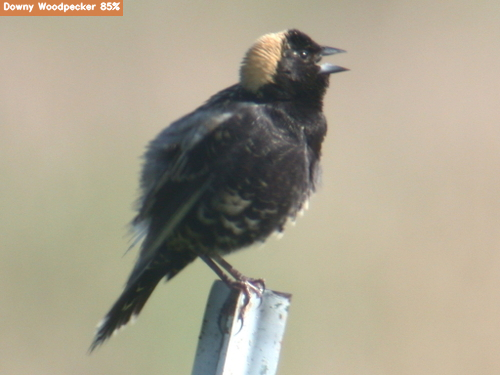

In [6]:
import cv2

from geti_sdk import Visualizer

# from geti_sdk.demos import EXAMPLE_IMAGE_PATH

numpy_image = cv2.imread(
    "/Users/rgangire/workspace/data/CUB_200_2011/CUB_200_2011/images/013.Bobolink/Bobolink_0099_9314.jpg"
)
numpy_rgb = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2RGB)

prediction = deployment.explain(numpy_rgb)
print(
    f"Predicted as : {prediction.get_label_names()[0]} with a probability: {100*prediction.annotations[0].labels[0].probability:.1f}%"
)
visualizer = Visualizer()
result = visualizer.draw(numpy_rgb, prediction)
visualizer.show_in_notebook(result)

In [ ]:
prediction = deployment.infer(numpy_rgb)